In [1]:
%load_ext Cython

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Testing Cython

In [43]:
def f(x):
    return x ** 2 - x

def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [13]:
%%timeit

integrate_f(0, 100, 10_000)

1.66 ms ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
%timeit -n 10 integrate_f(0, 100, 10_000)

2.08 ms ± 794 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%cython

def f(x):
    return x ** 2 - x

def c_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s
    cdef double dx
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [14]:
%%timeit

c_integrate_f(0, 100, 10_000)

1.28 ms ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
round(1.28 / 1.66, 3)

0.771

# A super C Cython version of our random walk

In [29]:
import sysconfig
print(sysconfig.get_paths()["include"])

/opt/conda/include/python3.11


In [24]:
!cythonize -i Basic2D.pyx

Compiling /home/jovyan/work/Basic2D.pyx because it changed.
[1/1] Cythonizing /home/jovyan/work/Basic2D.pyx


In [25]:
!ls *.so

Basic2D.cpython-311-aarch64-linux-gnu.so
Basic2D_pythonic.cpython-311-aarch64-linux-gnu.so


In [26]:
!g++ -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing \
-I/opt/conda/include/python3.11 -o Basic2D.cpython-311-aarch64-linux-gnu.so Basic2D.c \
-L/usr/local/lib -lgsl -lgslcblas -Wl,-rpath,/usr/local/lib

We had to do some debugging while figuring out how to link the cython version of the
random walk with gslcblas.so and we ended up checking the RPATH variable as follows:
```
$ readelf -d Basic2D.cpython-311-aarch64-linux-gnu.so | grep RPATH
 0x000000000000000f (RPATH)              Library rpath: [/opt/conda/lib]
```

In [27]:
import Basic2D
Basic2D.run_random_walks()

In [28]:
%timeit Basic2D.run_random_walks()

1.45 s ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# A more pythonic cython version

In [49]:
import numpy
print(numpy.get_include())

/opt/conda/lib/python3.11/site-packages/numpy/core/include


In [30]:
!cythonize -i Basic2D_pythonic.pyx

Compiling /home/jovyan/work/Basic2D_pythonic.pyx because it changed.
[1/1] Cythonizing /home/jovyan/work/Basic2D_pythonic.pyx


In [31]:
!ls *.so *.c

Basic2D.c
Basic2D.cpython-311-aarch64-linux-gnu.so
Basic2D_pythonic.c
Basic2D_pythonic.cpython-311-aarch64-linux-gnu.so


In [32]:
!g++ -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing \
-I/opt/conda/include/python3.11 -o Basic2D_pythonic.cpython-311-aarch64-linux-gnu.so Basic2D_pythonic.c

In [48]:
import Basic2D_pythonic
%timeit -n 2 -r 3 Basic2D_pythonic.run_random_walks_pythonic()

58.9 s ± 120 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


In [3]:
import numpy as np

np.random.randint(0, 4, size=3)

array([2, 2, 2])

In [7]:
%%cython

import numpy as np

directions = np.random.randint(0, 4, size=10)
print(directions)

[1 0 0 1 3 2 2 2 3 3]


In [36]:
%%cython

import numpy as np

cpdef run_random_walks_pythonic():
    cdef int sampleSize = 100
    cdef int minLength = 1
    cdef int maxLength = 50
    cdef int x, y
    cdef int stepLength = 1
    cdef int totalSteps, test, step
    cdef double dist, distTotal, distAvg

    for totalSteps in range(minLength, maxLength + 1):
        distTotal = 0
        for test in range(sampleSize):
            x = y = 0        
            directions = np.random.randint(0, 4, size=totalSteps)

            # Do the entire random walk.
            for step in range(totalSteps):
                # Directly use directions with Pythonic indexing
                direction = directions[step]
                if direction == 0: x += stepLength
                elif direction == 1: y += stepLength
                elif direction == 2: x -= stepLength
                else: y -= stepLength

            # Now that the walk is over, let's see how far we got.
            dist = x * x + y * y
            distTotal += dist

        print(totalSteps)
        distAvg = distTotal / sampleSize
        with open("Basic2D_pythonic.csv", "a") as output:
            output.write(f"{totalSteps},\t{distAvg:.3f}\n")

run_random_walks_pythonic()

In [51]:
%%writefile compile_cython.py
# We used this to cythonize a cython app and to tell it where to look for
# header files.

from Cython.Build import cythonize
from distutils.extension import Extension
import numpy

# Define your extension and include dirs
extensions = [
    Extension("Basic2D_pythonic", ["Basic2D_pythonic.pyx"], include_dirs=[numpy.get_include()])
]

# Use cythonize on the extension object
cythonize(extensions)

Writing compile_cython.py


In [66]:
!python compile_cython.py

In [67]:
!gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing \
-I/opt/conda/include/python3.11 -I/opt/conda/lib/python3.11/site-packages/numpy/core/include \
-o Basic2D_pythonic.so Basic2D_pythonic.c \
-L/usr/local/lib -lgsl -lgslcblas -Wl,-rpath,/usr/local/lib \
-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION

# Analysis

In [57]:
df = pd.read_csv("Basic2D.csv", header=None)
df.head()

,0,1
0,1,1.000
1,2,1.994
2,3,2.987
3,4,3.997
4,5,4.991


In [59]:
df[0].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [60]:
df[1].values

array([ 1.   ,  1.994,  2.987,  3.997,  4.991,  5.988,  7.001,  8.026,
        9.067, 10.006, 11.012, 12.029, 12.993, 14.011, 14.932, 15.958,
       17.035, 18.009, 19.008, 19.95 , 20.924, 22.074, 22.902, 23.987,
       25.045, 26.019, 27.024, 28.011, 28.988, 29.863, 31.119, 31.96 ,
       32.91 , 33.917, 34.914, 36.112, 37.18 , 37.899, 39.102, 39.948,
       41.195, 42.143, 43.087, 43.923, 45.151, 46.075, 47.142, 48.106,
       49.166, 49.794])

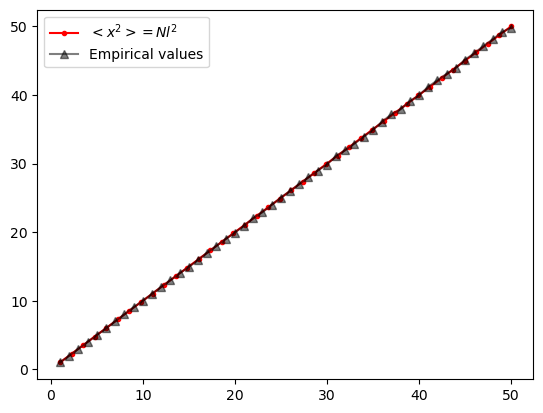

In [73]:
l = 1
x = np.linspace(1, 50, num=40)
predicted = x * l * l

plt.plot(x, predicted, marker=".", color="red", label="$<x^2> = N l^2$")

plt.plot(df[0].values, df[1].values, marker="^", color="black", alpha=0.5, label="Empirical values")

plt.legend()
plt.show()

# 3D Random Walk

In [9]:
def random_walk_3d():
    sampleSize = 100_000
    minLength = 1
    maxLength = 50

    stepLength = 2
    dist, distAvg = 0, 0

    # We will try something new now: it doesn't really matter now but branch predictions are
    # costly(er), so now we will assume that
    # index 0 corresponds to +x, 
    # index 1 corresponds to -x,
    # index 2 corresponds to +y,
    # index 3 corresponds to -y,
    # index 4 corresponds to +z,
    # index 5 corresponds to -z.
    distance = np.zeros(6)
    
    # Walk some totalSteps distance in total.
    for totalSteps in range(minLength, maxLength + 1):
        distTotal = 0

        # Do sampleSize trials of the entire random walk.
        for test in range(sampleSize):
            x = y = 0        
            
            directions = np.random.randint(0, 6, size=totalSteps)
            for step in directions:
                distance[step] += stepLength

            # Now that the walk is over, let's see how far we got.
            x = distance[0] - distance[1]
            y = distance[2] - distance[3]
            z = distance[4] - distance[5]
            dist = (x * x) + (y * y) + (z * z)
            distTotal += dist

        distAvg = distTotal / sampleSize
        with open("3d-walk.csv", "a") as output:
            output.write(f"{totalSteps},\t{distAvg:.3f}\n")

In [12]:
%%timeit -r 2 -n 1

random_walk_3d()

1min 25s ± 175 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [47]:
# Some tid bit for further optimization.
# Let's generate 3 samples of 5 steps each all at once.
directions = np.random.randint(0, 6, size=(3, 5))
directions

array([[3, 0, 3, 2, 1],
       [3, 1, 2, 1, 4],
       [3, 2, 1, 5, 3]])

In [48]:
# Axis 0 corresponds to a row.
# Axis 1 corresponds to a column.
# Let's pick a row and two column.
directions[0], directions[:, 0], directions[:, 1]

(array([3, 0, 3, 2, 1]), array([3, 3, 3]), array([0, 1, 2]))

In [69]:
# Count the occurences of each value in the first row.
np.bincount(directions[0], minlength=6)

array([1, 1, 1, 2, 0, 0])

In [70]:
# Count the ocurrences of each values in the first column: 0 0s, 0 1s, 0 2s, 3 3s, ...
np.bincount(directions[:, 0], minlength=6)

array([0, 0, 0, 3, 0, 0])

In [71]:
# Count the ocurrences of each values in the first column: 1 0s, 1 1s, 1 2s, 0 3s, ...
np.bincount(directions[:, 1], minlength=6)

array([1, 1, 1, 0, 0, 0])

In [76]:
# If axis=0, the function you provide is applied to each "column" of data because
# you’re moving along the rows (down each column).
# If axis=1, the function is applied to each "row" of data because you're moving along the columns (across each row).
#
# So we can apply bincount to do away with our innermost for loop.
# And we have to do it along axis=1, so that np.bincount() works on elements that are in the same row
# but different columns (horizontally). It "collapses" the column dimension (dimension 1), working across rows.
#
# We can use this sort of logic to count all the steps along a given direction for all
# the samples all at once. Instead of doing a "for each sample: for each step in direction: do the sum."
counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=6), 1, directions)
counts

array([[1, 1, 1, 2, 0, 0],
       [0, 2, 1, 1, 1, 0],
       [0, 1, 1, 2, 0, 1]])

In [63]:
def vectorized_random_walk_3d():
    sampleSize = 100_000
    minLength = 1
    maxLength = 50
    stepLength = 2

    # Initialize a file to store the results
    with open("3d-walk-vectorized.csv", "w") as output:
        output.write("TotalSteps,DistAvg\n")

    for totalSteps in range(minLength, maxLength + 1):
        # Generate all directions for all trials at once.
        directions = np.random.randint(0, 6, size=(sampleSize, totalSteps))

        # Count occurrences of each direction for each trial using a vectorized approach.
        counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=6), 1, directions)

        # Calculate net movement in each direction by subtracting opposite directions and multiply by stepLength.
        x_movements = (counts[:, 0] - counts[:, 1]) * stepLength
        y_movements = (counts[:, 2] - counts[:, 3]) * stepLength
        z_movements = (counts[:, 4] - counts[:, 5]) * stepLength

        # Calculate squared distances for each trial.
        dists = x_movements**2 + y_movements**2 + z_movements**2

        # Calculate and write the average squared distance for this number of steps.
        distAvg = np.mean(dists)

        with open("3d-walk-vectorized.csv", "a") as output:
            output.write(f"{totalSteps},{distAvg:.3f}\n")

In [43]:
%%timeit -r 5 -n 2

vectorized_random_walk_3d()

7.92 s ± 111 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [84]:
# This is the level of improvement of this numpy version against the C version of the 2D walk.
100 * ((75 - 7.9) / 7.9 )

849.3670886075948

In [64]:
import os

os.remove("3d-walk-vectorized.csv")
vectorized_random_walk_3d()

In [65]:
df = pd.read_csv("3d-walk-vectorized.csv")
df.head()

,TotalSteps,DistAvg
0,1,4.000
1,2,8.016
2,3,11.989
3,4,15.975
4,5,20.072


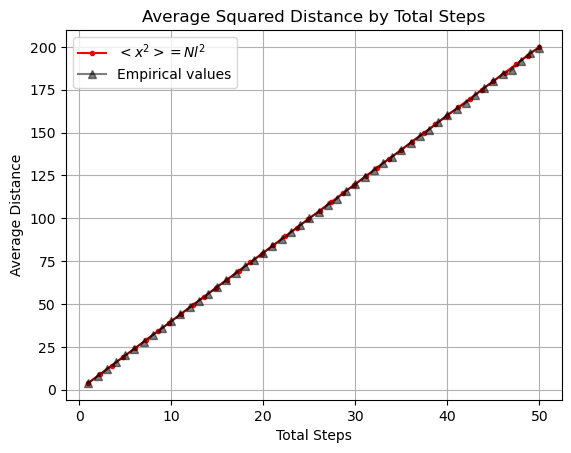

In [73]:
l = 2
x = np.linspace(1, 50, num=40)
predicted = x * l * l

plt.plot(x, predicted, marker=".", color="red", linestyle='-', label="$<x^2> = N l^2$")


plt.plot(df["TotalSteps"], df["DistAvg"], marker="^", color="black", alpha=0.5, label="Empirical values")

plt.title('Average Squared Distance by Total Steps')
plt.xlabel('Total Steps')
plt.ylabel('Average Distance')
plt.grid(True) 
plt.legend()
plt.show()